In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import json
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt


In [3]:
PIX3D_JSON = "/kaggle/input/pix3d-dataset/pix3d/pix3d.json"
PIX3D_ROOT = "/kaggle/input/pix3d-dataset/pix3d/"

with open(PIX3D_JSON, 'r') as f:
    pix3d_data = json.load(f)

print("Total items:", len(pix3d_data))
print("Sample keys:", pix3d_data[0].keys())


Total items: 10069
Sample keys: dict_keys(['img', 'category', 'img_size', '2d_keypoints', 'mask', 'img_source', 'model', 'model_raw', 'model_source', '3d_keypoints', 'voxel', 'rot_mat', 'trans_mat', 'focal_length', 'cam_position', 'inplane_rotation', 'truncated', 'occluded', 'slightly_occluded', 'bbox'])


In [5]:
class Pix3DDataset(Dataset):
    def __init__(self, metadata, root, transform=None, limit=None):
        self.data = metadata if limit is None else metadata[:limit]
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img_path = os.path.join(self.root, item["img"])
        voxel_path = os.path.join(self.root, item["voxel"])

        # Load image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Load voxel
        voxel_np = sio.loadmat(voxel_path)["voxel"]
        voxel = torch.tensor(voxel_np, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1,1,128,128,128)

        # ✅ Downsample to 32³
        voxel = torch.nn.functional.interpolate(voxel, size=(32, 32, 32), mode='trilinear', align_corners=False)
        voxel = voxel.squeeze(0)  # (1,32,32,32)

        return img, voxel


In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    
    transforms.ToTensor()
])

dataset = Pix3DDataset(pix3d_data, PIX3D_ROOT, transform, limit=1000)  # small subset for testing
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

print("Loaded samples:", len(dataset))


Loaded samples: 1000




This model is a sophisticated network designed to reconstruct a 3D object's shape (a voxel grid) from just a single 2D image. It has three main parts: an Encoder, an Attention Bottleneck, and a 3D Decoder.

1. The 2D Encoder: Image Feature Extraction

The Encoder processes the input image to find key visual features.

Input: An RGB image, like a photo, with dimensions $3 \times 128 \times 128$ (Color channels $\times$ Height $\times$ Width).

Process: The model uses four main convolutional blocks, each one performing two actions:

It halves the image size (e.g., $128 \rightarrow 64 \rightarrow 32 \rightarrow 16 \rightarrow 8$).

It increases the feature channels (from 3 up to 512).

Encoder Output: A deep feature map of size $(\text{BatchSize}, 512, 8, 8)$. This is a compressed 2D summary of the image.

2. Attention Mechanism: Refining Features

Right after the encoder, an attention block helps the model focus on the most important parts of the features.

Process: A small convolution creates an attention mask (a set of weights) using the Sigmoid function.

Purpose: This mask is multiplied by the features, which allows the network to selectively weigh the importance of different regions, ensuring the best visual information for 3D reconstruction is prioritized.

3. Bottleneck: Latent Vector Compression

The bottleneck takes the refined 2D features and converts them into a compact, numerical code.

Flattening: The $8 \times 8 \times 512$ feature map is flattened into a long vector (32,768 numbers).

Fully Connected Layers: These layers compress the long vector down to a much smaller Latent Vector of 2,048 numbers.

Output: The Latent Vector is a dense code that encapsulates the entire 3D shape of the object seen in the image.

4. The 3D Decoder: Voxel Grid Reconstruction

The Decoder is the generator. It takes the compressed latent code and builds the 3D shape from it.

Initial Step: The 2,048-number latent vector is reshaped into a tiny $1 \times 1 \times 1$ block. This small block is the seed for the 3D structure.

Process: The decoder uses seven blocks of 3D Transposed Convolutions (often called "deconvolution").

In each block, the spatial dimensions (Depth, Height, Width) are doubled.

The volume grows progressively from $1 \times 1 \times 1$ up to $128 \times 128 \times 128$.

The channels are simultaneously halved (from 2048 down to 16).

5. Final Output Layer

The last step creates the final 3D shape.

Final Convolutions: Reduce the feature channels down to a single channel (1).

Sigmoid Activation: This function ensures all final output values are between 0 and 1.

Output: A 3D Voxel Grid of size $(\text{BatchSize}, 1, 128, 128, 128)$. Each number in the grid represents the probability that the corresponding 3D point is occupied by the object.

Summary of the Data Flow

The entire model works as a pipeline to map the visual input to the volumetric output:

$$(\text{Image: } 3 \times 128^2) \xrightarrow[\text{Conv2D + Attention}]{\text{Encoder}} (\text{Features: } 512 \times 8^2)$$

$$(\text{Features}) \xrightarrow[\text{Linear Layers}]{\text{Bottleneck}} (\text{Latent Vector: } 2048)$$

$$(\text{Latent Vector}) \xrightarrow[\text{ConvTranspose3D}]{\text{Decoder}} (\text{Voxel Grid: } 1 \times 128^3)$$

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImprovedVoxelAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()


In [9]:
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, voxels in dataloader:
        imgs, voxels = imgs.to(device), voxels.to(device)
         # 1. Forward Pass & Loss Calculation: Compute the predicted output and the error.
        preds = model(imgs)
        loss = criterion(preds, voxels)
         # 2. Backpropagation: Zero out old gradients and compute new ones based on the loss.
        optimizer.zero_grad()
        loss.backward()
        # 3. Optimization: Update the model's parameters in the direction that minimizes loss.
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss / len(dataloader):.4f}")


ValueError: Using a target size (torch.Size([2, 1, 32, 32, 32])) that is different to the input size (torch.Size([2, 1, 128, 128, 128])) is deprecated. Please ensure they have the same size.

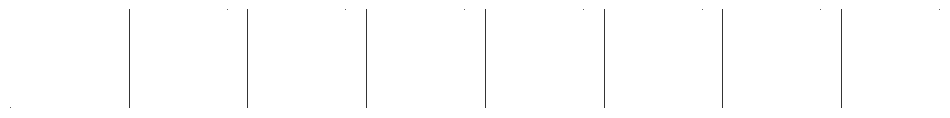

In [10]:
model.eval()
imgs, voxels = next(iter(dataloader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = model(imgs)

voxel_pred = preds[0, 0].cpu().numpy()
vox = (voxel_pred > 0.5)

plt.figure(figsize=(12, 2))
for i in range(0, vox.shape[0], 16):
    plt.subplot(1, 8, i // 16 + 1)
    plt.imshow(vox[i], cmap='gray')
    plt.axis('off')
plt.show()


In [11]:
import numpy as np

def evaluate_voxel_metrics(preds, targets, threshold=0.5):
    """
    preds, targets: torch tensors (B, 1, D, H, W)
    threshold: binarization threshold
    """
    preds_bin = (preds > threshold).float()
    targets_bin = (targets > threshold).float()

    tp = (preds_bin * targets_bin).sum().item()
    fp = (preds_bin * (1 - targets_bin)).sum().item()
    fn = ((1 - preds_bin) * targets_bin).sum().item()
    tn = ((1 - preds_bin) * (1 - targets_bin)).sum().item()

    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)

    return {
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "Accuracy": acc
    }


In [ ]:
model.eval()
imgs, voxels = next(iter(dataloader))
imgs, voxels = imgs.to(device), voxels.to(device)

with torch.no_grad():
    preds = model(imgs)

metrics = evaluate_voxel_metrics(preds, voxels, threshold=0.5)
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")


# chairs


# PIX3D Chair Data Selector

This code block performs data preprocessing by loading the full metadata for the PIX3D dataset and filtering it to create a specific subset.

## Core Function

The primary job is to identify and isolate all metadata entries related to chairs for training the 2D-to-3D autoencoder.

Load: It first loads all object metadata from the primary JSON file (PIX3D_JSON).

Filter: It iterates through every record and uses a heuristic approach to check for the presence of the word "chair" within three key fields: the image file path, the 3D model path, and the explicit category name (if present).

Output: It produces a filtered list (chairs) containing only the relevant training examples and prints a count to confirm how many chair items were found.



In [12]:

with open(PIX3D_JSON, 'r') as f:
    metadata = json.load(f)

# Filter heuristically for chairs: look in img or model path or 'category' key if present
chairs = []
for item in metadata:
    # many pix3d metadata keys: 'img','model','category' etc.
    img = item.get("img","").lower()
    model = item.get("model","").lower()
    cat = item.get("category","").lower() if item.get("category") else ""
    if ("chair" in img) or ("chair" in model) or ("chair" in cat):
        chairs.append(item)

print(f"Total metadata items: {len(metadata)}, chair items found: {len(chairs)}")
# inspect one
if len(chairs)>0:
    print("example chair item keys:", list(chairs[0].keys()))


Total metadata items: 10069, chair items found: 3839
example chair item keys: ['img', 'category', 'img_size', '2d_keypoints', 'mask', 'img_source', 'model', 'model_raw', 'model_source', '3d_keypoints', 'voxel', 'rot_mat', 'trans_mat', 'focal_length', 'cam_position', 'inplane_rotation', 'truncated', 'occluded', 'slightly_occluded', 'bbox']


In [23]:
# Dataset (chair-only)
class Pix3DChairDataset(Dataset):
    def __init__(self, items, root, transform=None):
        """
        items: list of metadata dicts filtered to chairs
        """
        self.items = items
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        img_path = os.path.join(self.root, it["img"])
        voxel_path = os.path.join(self.root, it["voxel"])

        # load image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # load voxel (mat with key 'voxel')
        mat = sio.loadmat(voxel_path)
        # safe extraction
        if "voxel" in mat:
            voxel_np = mat["voxel"]
        elif "vox" in mat:
            voxel_np = mat["vox"]
        else:
            # fallback: try to find first 3d array
            voxel_np = None
            for v in mat.values():
                if isinstance(v, np.ndarray) and v.ndim == 3:
                    voxel_np = v
                    break
            if voxel_np is None:
                raise RuntimeError(f"no 3D array found in {voxel_path}")

        voxel = torch.tensor(voxel_np, dtype=torch.float32).unsqueeze(0)  # (1,128,128,128)
        return img, voxel




## 🔹 1. Define Image Transforms
A transformation pipeline is created using `transforms.Compose()` which:
- Resizes each image to **128×128**
- Converts the image into a **PyTorch tensor**

---

## 🔹 2. Limit Dataset Size (Optional)
A variable `LIMIT` lets you use only a subset of chairs (e.g., 1000) for faster experiments.  
If `LIMIT` is `None`, the entire dataset is used.

---

## 🔹 3. Create the Custom Dataset
`Pix3DChairDataset()` is instantiated using:
- The selected list of chair items
- The root directory path
- The transform pipeline

This gives a PyTorch-compatible dataset that loads images + voxel data.

---

## 🔹 4. Print Dataset Size
The line `print("chair dataset size:", len(dataset))` shows how many items are available after applying the limit.

---

## 🔹 5. Train/Test Split (80/20)
The dataset is split into:
- **80% training samples**
- **20% testing samples**

A safety check ensures at least **one training sample** exists.

---

## 🔹 6. Create DataLoaders
Two `DataLoader`s are created:

- **train_loader**
  - `shuffle=True` for better learning
  - Loads data in batches of 8
  - Uses `num_workers=2` for faster loading
  - Uses `pin_memory=True` to speed up GPU transfers

- **test_loader**
  - `shuffle=False`
  - Same batch size and worker settings

DataLoaders help iterate efficiently over the dataset during training.

---

## 🔹 7. Print Final Train/Test Counts
Shows how many samples are in each split for verification.

---


In [24]:
import os
import json
import numpy as np
from PIL import Image
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split   # ✅ <- this fixes your error
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Cell 4 - transforms + split + dataloaders
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

# optionally limit for quick experiments; set to None to use all chairs
LIMIT = 1000  # or e.g. 200
items = chairs if LIMIT is None else chairs[:LIMIT]

dataset = Pix3DChairDataset(items, PIX3D_ROOT, transform=transform)
print("chair dataset size:", len(dataset))

# train/test split 80/20
train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
if train_len == 0:
    # ensure there's at least 1 train sample
    train_len = max(1, len(dataset)-1)
    test_len = len(dataset)-train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len])

batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("train:", len(train_ds), "test:", len(test_ds))


chair dataset size: 1000
train: 800 test: 200


# ImprovedVoxelAutoencoder — Short Explanation

This model converts a **2D RGB image (128×128)** into a **3D voxel grid (128³)** using a 2D encoder, a latent bottleneck, and a 3D decoder.

---

## 🔹 Encoder (2D → Latent)

* Four Conv2D blocks: (3→64), (64→128), (128→256), (256→512)
* Each block: Conv2D + BatchNorm + LeakyReLU
* Image size reduces: **128 → 8**
* Output features: **512×8×8**

---

## 🔹 Attention Module

* 1×1 Conv + Sigmoid creates an attention mask
* Multiplied with encoder output to highlight important features

---

## 🔹 Latent Vector (Bottleneck)

* Flatten (512×8×8) → 32768
* Fully Connected network reduces to **2048-dim latent vector**

---

## 🔹 Decoder (Latent → 3D Voxels)

* Latent reshaped to **(2048×1×1×1)**
* Seven ConvTranspose3D blocks upsample:

  * 1→2 → 4 → 8 → 16 → 32 → 64 → **128**
* Channels reduce: 2048 → ... → 16

---

## 🔹 Final Output Layer

* Conv3D → BN → LeakyReLU → Conv3D → Sigmoid
* Produces **1×128×128×128 voxel grid** (values 0–1)

---

## 🔹 Forward Pass Summary

**Image → Encoder → Attention → FC Latent → 3D Decoder → Voxel Output (128³)**

---


In [ ]:
# model definition (128^3 output)
class ImprovedVoxelAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder 2D
        self.enc1 = nn.Sequential(nn.Conv2d(3,64,5,stride=2,padding=2), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True))
        self.enc2 = nn.Sequential(nn.Conv2d(64,128,5,stride=2,padding=2), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True))
        self.enc3 = nn.Sequential(nn.Conv2d(128,256,5,stride=2,padding=2), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True))
        self.enc4 = nn.Sequential(nn.Conv2d(256,512,5,stride=2,padding=2), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, True))

        self.attention = nn.Sequential(nn.Conv2d(512,512,1), nn.Sigmoid())

        self.fc_enc = nn.Sequential(
            nn.Linear(512*8*8, 2048),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(2048, 2048)
        )

        # Decoder 3D to 128^3
        self.dec1 = self._decoder_block(2048, 1024)  # 1->2
        self.dec2 = self._decoder_block(1024, 512)   # 2->4
        self.dec3 = self._decoder_block(512, 256)    # 4->8
        self.dec4 = self._decoder_block(256, 128)    # 8->16
        self.dec5 = self._decoder_block(128, 64)     # 16->32
        self.dec6 = self._decoder_block(64, 32)      # 32->64
        self.dec7 = self._decoder_block(32, 16)      # 64->128

        self.final_conv = nn.Sequential(
            nn.Conv3d(16, 8, 3, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.2, True),
            nn.Conv3d(8, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def _decoder_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose3d(in_ch, out_ch, 4, stride=2, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.LeakyReLU(0.2, True)
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        attn = self.attention(x)
        x = x * attn
        x = x.view(x.size(0), -1)
        latent = self.fc_enc(x)
        x = latent.view(-1, 2048, 1, 1, 1)
        x = self.dec1(x)
        x = self.dec2(x)
        x = self.dec3(x)
        x = self.dec4(x)
        x = self.dec5(x)
        x = self.dec6(x)
        x = self.dec7(x)
        out = self.final_conv(x)
        return out

# instantiate
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImprovedVoxelAutoencoder().to(device)
print("Model ready, device:", device)


# Training Setup & Metrics

This code initializes training with **Adam optimizer** and **BCELoss**, then defines a metric function that thresholds voxel predictions at 0.5 and computes **IoU, Precision, Recall, F1-score, and Accuracy** by counting TP/FP/FN/TN across the full 128³ voxel grid, finally returning the average values across the batch.


In [ ]:
#  training setup + metric helper
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.BCELoss()  # since final activation is Sigmoid

def evaluate_voxel_metrics(preds, targets, threshold=0.5):
    preds_bin = (preds > threshold).float()
    targets_bin = (targets > threshold).float()
    tp = (preds_bin * targets_bin).sum(dim=[1,2,3,4]).cpu().numpy()  # per-sample
    fp = (preds_bin * (1 - targets_bin)).sum(dim=[1,2,3,4]).cpu().numpy()
    fn = ((1 - preds_bin) * targets_bin).sum(dim=[1,2,3,4]).cpu().numpy()
    tn = ((1 - preds_bin) * (1 - targets_bin)).sum(dim=[1,2,3,4]).cpu().numpy()

    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)

    # return averages across batch
    return {
        "IoU": float(iou.mean()),
        "Precision": float(precision.mean()),
        "Recall": float(recall.mean()),
        "F1": float(f1.mean()),
        "Accuracy": float(acc.mean())
    }


# Training Loop 

This training loop runs for several epochs, where each epoch trains the model on mini-batches of images and voxel grids using **Adam + BCELoss**, performs backpropagation to update weights, and then evaluates on the test set by computing **IoU, Precision, Recall, F1-score, and Accuracy** for each batch. The metrics are averaged across all test batches, printed for monitoring, and the model is saved whenever it achieves a **new highest IoU**, ensuring the best-performing checkpoint is stored.


In [ ]:
#  training loop
epochs = 6  # adjust as needed
best_iou = -1.0

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} train")
    for imgs, voxels in pbar:
        imgs = imgs.to(device)
        voxels = voxels.to(device)  # shape: [B,1,128,128,128]
        preds = model(imgs)         # same shape
        loss = criterion(preds, voxels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.set_postfix(loss=train_loss/(pbar.n+1))

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # evaluate on test set each epoch
    model.eval()
    metrics_accum = {"IoU":0,"Precision":0,"Recall":0,"F1":0,"Accuracy":0}
    batches = 0
    with torch.no_grad():
        for imgs, voxels in test_loader:
            imgs = imgs.to(device)
            voxels = voxels.to(device)
            preds = model(imgs)
            m = evaluate_voxel_metrics(preds, voxels, threshold=0.5)
            for k in metrics_accum:
                metrics_accum[k] += m[k]
            batches += 1

    for k in metrics_accum: metrics_accum[k] /= max(1, batches)
    print("Validation metrics:", {k: f"{v:.4f}" for k,v in metrics_accum.items()})

    # save best
    if metrics_accum["IoU"] > best_iou:
        best_iou = metrics_accum["IoU"]
        torch.save(model.state_dict(), "best_chair_autoencoder_128.pth")
        print(f"Saved best model with IoU={best_iou:.4f}")


# Optimized Training Loop 

This code trains the model using **mixed precision** for speed, a **hybrid Weighted BCE + Dice loss** for better voxel reconstruction, and **Adam optimizer** with gradient scaling. Each epoch performs forward and backward passes on batches, updates weights, then evaluates the model on the test set using IoU, Precision, Recall, F1, and Accuracy. It also prints mean voxel values for sanity checking and saves the model whenever a new best IoU is achieved.


In [ ]:
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from tqdm import tqdm

# -------------------------------
# ✅ Weighted BCE + Dice Hybrid Loss
# -------------------------------
class WeightedBCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.7, pos_weight=8.0):
        super().__init__()
        self.bce_weight = bce_weight
        self.pos_weight = pos_weight

    def forward(self, preds, targets):
        # Weighted BCE
        bce = - (self.pos_weight * targets * torch.log(preds + 1e-6) +
                 (1 - targets) * torch.log(1 - preds + 1e-6))
        bce = bce.mean()

        # Dice loss
        smooth = 1e-5
        preds_flat = preds.view(-1)
        targets_flat = targets.view(-1)
        intersection = (preds_flat * targets_flat).sum()
        dice = 1 - (2. * intersection + smooth) / (
            preds_flat.sum() + targets_flat.sum() + smooth
        )

        return self.bce_weight * bce + (1 - self.bce_weight) * dice


# -------------------------------
# ⚙️ Training Setup
# -------------------------------
criterion = WeightedBCEDiceLoss(bce_weight=0.7, pos_weight=8.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = GradScaler()

# Function to evaluate metrics
def evaluate_voxel_metrics(preds, targets, threshold=0.5):
    preds_bin = (preds > threshold).float()
    targets_bin = (targets > threshold).float()
    tp = (preds_bin * targets_bin).sum().item()
    fp = (preds_bin * (1 - targets_bin)).sum().item()
    fn = ((1 - preds_bin) * targets_bin).sum().item()
    tn = ((1 - preds_bin) * (1 - targets_bin)).sum().item()

    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    return {"IoU": iou, "Precision": precision, "Recall": recall, "F1": f1, "Accuracy": acc}


# -------------------------------
# 🔁 Optimized Training Loop
# -------------------------------
epochs = 10
best_iou = 0.0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} train")
    for imgs, voxels in pbar:
        imgs, voxels = imgs.to(device), voxels.to(device)
        optimizer.zero_grad()

        # ⚡ Mixed precision training
        with autocast():
            preds = model(imgs)
            loss = criterion(preds, voxels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    avg_train_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # -------------------------------
    # 🧪 Validation
    # -------------------------------
    model.eval()
    val_metrics = {"IoU": 0, "Precision": 0, "Recall": 0, "F1": 0, "Accuracy": 0}
    val_batches = 0

    with torch.no_grad():
        for imgs, voxels in test_loader:
            imgs, voxels = imgs.to(device), voxels.to(device)
            preds = model(imgs)
            m = evaluate_voxel_metrics(preds, voxels)
            for k in val_metrics:
                val_metrics[k] += m[k]
            val_batches += 1

    for k in val_metrics:
        val_metrics[k] /= max(1, val_batches)
    print("Validation metrics:", {k: f"{v:.4f}" for k, v in val_metrics.items()})

    # -------------------------------
    # 🧠 Log voxel occupancy (sanity check)
    # -------------------------------
    with torch.no_grad():
        sample_img, sample_vox = next(iter(test_loader))
        sample_img, sample_vox = sample_img.to(device), sample_vox.to(device)
        sample_pred = model(sample_img)
        print(f"Mean predicted voxel value: {sample_pred.mean().item():.6f}, "
              f"GT mean: {sample_vox.mean().item():.6f}")

    # -------------------------------
    # 💾 Save best model
    # -------------------------------
    if val_metrics["IoU"] > best_iou:
        best_iou = val_metrics["IoU"]
        torch.save(model.state_dict(), f"best_model_epoch{epoch+1}_IoU{best_iou:.4f}.pth")
        print(f"✅ Saved best model with IoU={best_iou:.4f}")


# Upgraded 128³ Fine-Tune Model

In [19]:
import torch
import torch.nn as nn

class ImprovedVoxelAutoencoder128(nn.Module):
    def __init__(self):
        super().__init__()

        # ----------- 2D Encoder -----------
        self.enc1 = nn.Sequential(nn.Conv2d(3,64,5,2,2), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True))
        self.enc2 = nn.Sequential(nn.Conv2d(64,128,5,2,2), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True))
        self.enc3 = nn.Sequential(nn.Conv2d(128,256,5,2,2), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True))
        self.enc4 = nn.Sequential(nn.Conv2d(256,512,5,2,2), nn.BatchNorm2d(512), nn.LeakyReLU(0.2, True))

        self.attention = nn.Sequential(nn.Conv2d(512,512,1), nn.Sigmoid())

        # ----------- Larger Bottleneck -----------
        self.fc_enc = nn.Sequential(
            nn.Linear(512 * 8 * 8, 4096),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(4096, 2048)
        )

        # ----------- 3D Decoder (→128³) -----------
        self.dec1 = self._dec_block(2048,1024)  # 1→2
        self.dec2 = self._dec_block(1024,512)   # 2→4
        self.dec3 = self._dec_block(512,256)    # 4→8
        self.dec4 = self._dec_block(256,128)    # 8→16
        self.dec5 = self._dec_block(128,64)     # 16→32
        self.dec6 = self._dec_block(64,32)      # 32→64
        self.dec7 = self._dec_block(32,16)      # 64→128

        self.final_conv = nn.Sequential(
            nn.Conv3d(16,8,3,padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.2, True),
            nn.Conv3d(8,1,3,padding=1),
            nn.Sigmoid()
        )

    def _dec_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose3d(in_ch, out_ch, 4, stride=2, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.LeakyReLU(0.2, True)
        )

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.enc3(x)
        x = self.enc4(x)
        attn = self.attention(x)
        x = x * attn
        x = x.view(x.size(0), -1)
        latent = self.fc_enc(x)

        x = latent.view(-1, 2048, 1, 1, 1)
        x = self.dec1(x); x = self.dec2(x); x = self.dec3(x)
        x = self.dec4(x); x = self.dec5(x); x = self.dec6(x); x = self.dec7(x)
        out = self.final_conv(x)
        return out


In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_128 = ImprovedVoxelAutoencoder128().to(device)

# ✅ Load pretrained 64³ weights (partial)
checkpoint_path = "/kaggle/working/best_chair_autoencoder_128.pth"  # replace with your filename
ckpt = torch.load(checkpoint_path, map_location=device)

# Ignore missing decoder layers (dec7, final_conv)
model_dict = model_128.state_dict()
pretrained_dict = {k: v for k, v in ckpt.items() if k in model_dict and v.size() == model_dict[k].size()}
model_dict.update(pretrained_dict)
model_128.load_state_dict(model_dict)
print(f"Loaded {len(pretrained_dict)} matching layers from 64³ checkpoint.")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/best_chair_autoencoder_128.pth'

# Loss, Optimizer, Scheduler 

This code defines a **Weighted BCE + Dice hybrid loss** that balances voxel sparsity and shape accuracy, sets up an **Adam optimizer** with weight decay, and enables **mixed-precision training** using `GradScaler` for faster GPU performance. It also adds a **StepLR scheduler** to gradually reduce the learning rate every 10 epochs, helping stabilize long-term training. The metric function thresholds predictions and computes **IoU, Precision, Recall, F1, and Accuracy** using voxel-wise TP, FP, FN, and TN counts.


In [25]:
from torch.cuda.amp import autocast, GradScaler
import torch.optim as optim

# Weighted BCE + Dice loss again
class WeightedBCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.6, pos_weight=4.0):
        super().__init__()
        self.bce_weight = bce_weight
        self.pos_weight = pos_weight
    def forward(self, preds, targets):
        bce = - (self.pos_weight * targets * torch.log(preds + 1e-6) +
                 (1 - targets) * torch.log(1 - preds + 1e-6))
        bce = bce.mean()
        smooth = 1e-5
        p = preds.view(-1); t = targets.view(-1)
        inter = (p * t).sum()
        dice = 1 - (2 * inter + smooth) / (p.sum() + t.sum() + smooth)
        return self.bce_weight * bce + (1 - self.bce_weight) * dice

criterion = WeightedBCEDiceLoss(bce_weight=0.6, pos_weight=4.0)
optimizer = optim.Adam(model_128.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = GradScaler("cuda")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

def evaluate_voxel_metrics(preds, targets, th=0.5):
    pb = (preds > th).float(); tb = (targets > th).float()
    tp = (pb * tb).sum().item(); fp = (pb * (1 - tb)).sum().item()
    fn = ((1 - pb) * tb).sum().item(); tn = ((1 - pb)*(1 - tb)).sum().item()
    e = 1e-8
    iou = tp/(tp+fp+fn+e); prec = tp/(tp+fp+e); rec = tp/(tp+fn+e)
    f1 = 2*prec*rec/(prec+rec+e); acc = (tp+tn)/(tp+tn+fp+fn+e)
    return {"IoU":iou,"Precision":prec,"Recall":rec,"F1":f1,"Accuracy":acc}


/tmp/ipykernel_48/590523398.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler("cuda")


# Fine-Tuning + Visualization Loop

This code fine-tunes the 128³ voxel model using **mixed-precision training (AMP)**, logs training loss and validation metrics each epoch, and visualizes results. It performs forward and backward passes with gradient scaling, computes IoU, Precision, Recall, F1, and Accuracy on the test set, and saves the model whenever it achieves a significantly better IoU. Throughout training it stores all metrics in a history dictionary, then generates plots for **Training Loss vs IoU** and **Validation Metrics**, and finally displays a tabular summary along with the best epoch’s performance.


FineTune 1/5: 100%|██████████| 100/100 [01:33<00:00,  1.07it/s, loss=0.732]


Epoch 1 train loss: 0.7316


Validation metrics: {'IoU': '0.1718', 'Precision': '0.1843', 'Recall': '0.7297', 'F1': '0.2913', 'Accuracy': '0.8405'}
Mean predicted voxel value: 0.349734, GT mean: 0.056387
✅ Saved best 128³ model with IoU=0.1718


FineTune 2/5: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s, loss=0.61]


Epoch 2 train loss: 0.6102


Validation metrics: {'IoU': '0.2046', 'Precision': '0.2431', 'Recall': '0.5669', 'F1': '0.3359', 'Accuracy': '0.9002'}
Mean predicted voxel value: 0.209809, GT mean: 0.056387
✅ Saved best 128³ model with IoU=0.2046


FineTune 3/5: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=0.561]


Epoch 3 train loss: 0.5615


Validation metrics: {'IoU': '0.1936', 'Precision': '0.2176', 'Recall': '0.6455', 'F1': '0.3218', 'Accuracy': '0.8783'}
Mean predicted voxel value: 0.204596, GT mean: 0.056387


FineTune 4/5: 100%|██████████| 100/100 [01:26<00:00,  1.16it/s, loss=0.538]


Epoch 4 train loss: 0.5384


Validation metrics: {'IoU': '0.2142', 'Precision': '0.2651', 'Recall': '0.5351', 'F1': '0.3488', 'Accuracy': '0.9109'}
Mean predicted voxel value: 0.142777, GT mean: 0.056387
✅ Saved best 128³ model with IoU=0.2142


FineTune 5/5: 100%|██████████| 100/100 [01:25<00:00,  1.18it/s, loss=0.525]


Epoch 5 train loss: 0.5249


Validation metrics: {'IoU': '0.2083', 'Precision': '0.2491', 'Recall': '0.5721', 'F1': '0.3418', 'Accuracy': '0.9023'}
Mean predicted voxel value: 0.148563, GT mean: 0.056387


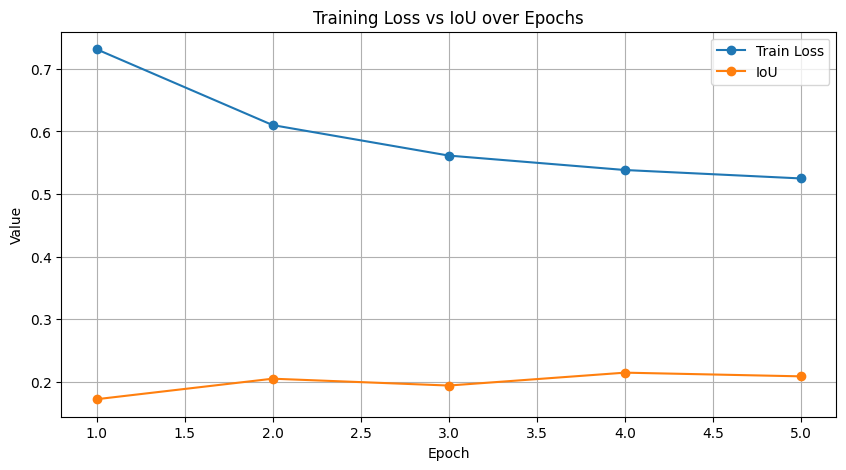

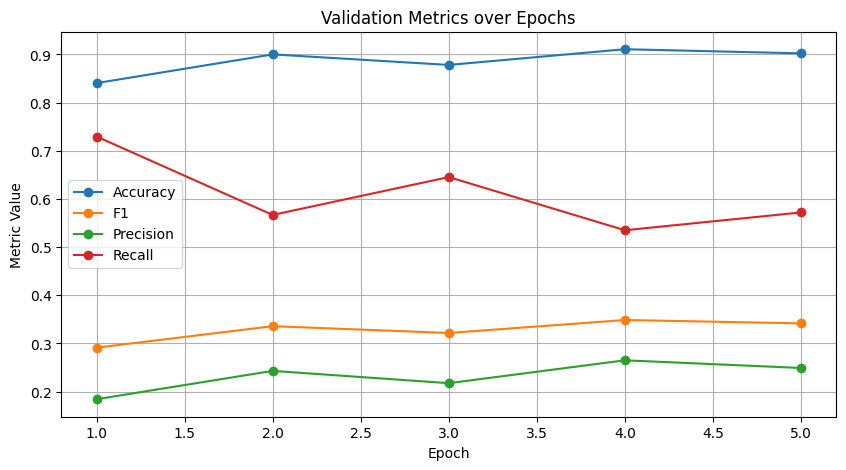


📊 Final Metrics Overview:


,Epoch,Train Loss,IoU,Precision,Recall,F1,Accuracy
0,1,0.731597,0.171752,0.184305,0.729694,0.291328,0.840525
1,2,0.610244,0.204586,0.243143,0.566873,0.335919,0.900172
2,3,0.561464,0.193629,0.217613,0.645451,0.321827,0.878261
3,4,0.538385,0.214246,0.265099,0.535108,0.348758,0.910893
4,5,0.524896,0.208341,0.249147,0.572062,0.341802,0.902294



🏆 Best Epoch: 4
Epoch         4.000000
Train Loss    0.538385
IoU           0.214246
Precision     0.265099
Recall        0.535108
F1            0.348758
Accuracy      0.910893
Name: 3, dtype: float64


In [26]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Safe AMP import
try:
    from torch import amp
    autocast = lambda: amp.autocast(device_type="cuda")
    GradScaler = amp.GradScaler
except ImportError:
    from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

epochs = 5
best_iou = 0.0

# ✅ To store metrics for visualization
history = {
    "Epoch": [],
    "Train Loss": [],
    "IoU": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "Accuracy": []
}

# ------------------- Training Loop -------------------
for epoch in range(epochs):
    model_128.train()
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"FineTune {epoch+1}/{epochs}")

    for imgs, voxels in pbar:
        imgs, voxels = imgs.to(device), voxels.to(device)
        optimizer.zero_grad()

        with autocast():
            preds = model_128(imgs)
            loss = criterion(preds, voxels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pbar.set_postfix(loss=total_loss / (pbar.n + 1))

    avg_train_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # ---------------- Validation ----------------
    model_128.eval()
    val_metrics = {"IoU": 0, "Precision": 0, "Recall": 0, "F1": 0, "Accuracy": 0}

    with torch.no_grad():
        for imgs, voxels in test_loader:
            imgs, voxels = imgs.to(device), voxels.to(device)
            preds = model_128(imgs)
            m = evaluate_voxel_metrics(preds, voxels)
            for k in val_metrics:
                val_metrics[k] += m[k]

    for k in val_metrics:
        val_metrics[k] /= len(test_loader)

    print("Validation metrics:", {k: f"{v:.4f}" for k, v in val_metrics.items()})

    # ---------------- Occupancy Log ----------------
    with torch.no_grad():
        sample_img, sample_vox = next(iter(test_loader))
        sample_img, sample_vox = sample_img.to(device), sample_vox.to(device)
        sample_pred = model_128(sample_img)
        print(f"Mean predicted voxel value: {sample_pred.mean().item():.6f}, "
              f"GT mean: {sample_vox.mean().item():.6f}")

    scheduler.step()

    # ---------------- Save Best ----------------
    if val_metrics["IoU"] - best_iou > 0.001:
        best_iou = val_metrics["IoU"]
        save_path = f"best_model_128_epoch{epoch+1}_IoU{best_iou:.4f}.pth"
        torch.save(model_128.state_dict(), save_path)
        print(f"✅ Saved best 128³ model with IoU={best_iou:.4f}")

    # ✅ Store history
    history["Epoch"].append(epoch + 1)
    history["Train Loss"].append(avg_train_loss)
    for k in val_metrics:
        history[k].append(val_metrics[k])

# ------------------- Visualization -------------------
df = pd.DataFrame(history)

# --- 1️⃣ Plot Loss and IoU ---
plt.figure(figsize=(10,5))
plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss", marker='o')
plt.plot(df["Epoch"], df["IoU"], label="IoU", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss vs IoU over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("training_loss_iou.png")
plt.show()

# --- 2️⃣ Plot Accuracy, F1, Precision, Recall ---
plt.figure(figsize=(10,5))
plt.plot(df["Epoch"], df["Accuracy"], label="Accuracy", marker='o')
plt.plot(df["Epoch"], df["F1"], label="F1", marker='o')
plt.plot(df["Epoch"], df["Precision"], label="Precision", marker='o')
plt.plot(df["Epoch"], df["Recall"], label="Recall", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validation Metrics over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("validation_metrics.png")
plt.show()

# --- 3️⃣ Display Table Summary ---
print("\n📊 Final Metrics Overview:")
display(df.tail())

# --- 4️⃣ Best Epoch Summary ---
best_epoch = df.loc[df["IoU"].idxmax()]
print(f"\n🏆 Best Epoch: {int(best_epoch['Epoch'])}")
print(best_epoch)


In [ ]:
# rm -rf /kaggle/working/*


#  ****Inference****

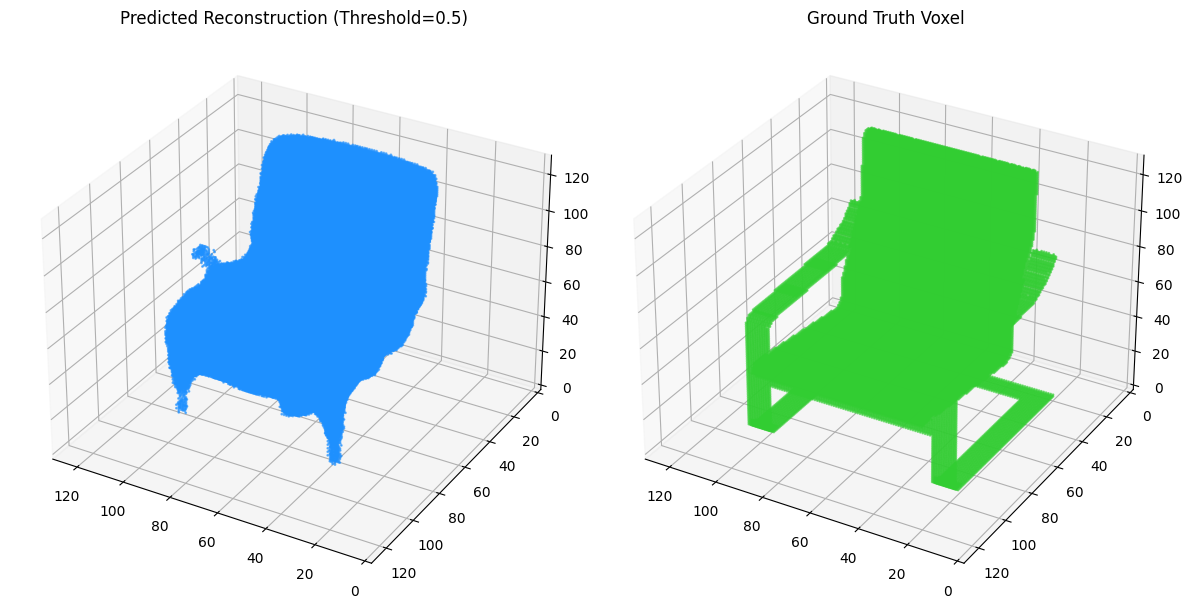

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Pick one test sample
model_128.eval()
imgs, voxels = next(iter(test_loader))
imgs, voxels = imgs.to(device), voxels.to(device)

with torch.no_grad():
    preds = model_128(imgs)

# Convert to numpy
pred = preds[0, 0].cpu().numpy()
gt = voxels[0, 0].cpu().numpy()

# Threshold predictions
pred_bin = (pred > 0.5)
gt_bin = (gt > 0.5)

# Get coordinates of occupied voxels
pred_points = np.argwhere(pred_bin)
gt_points = np.argwhere(gt_bin)

# Plot predicted vs ground truth
fig = plt.figure(figsize=(12,6))

# --- Predicted Reconstruction ---
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pred_points[:,0], pred_points[:,1], pred_points[:,2],
           s=1, c='dodgerblue', alpha=0.6)
ax.set_title("Predicted Reconstruction (Threshold=0.5)")
ax.set_xlim(0,128); ax.set_ylim(0,128); ax.set_zlim(0,128)
ax.view_init(elev=30, azim=120)

# --- Ground Truth ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(gt_points[:,0], gt_points[:,1], gt_points[:,2],
            s=1, c='limegreen', alpha=0.6)
ax2.set_title("Ground Truth Voxel")
ax2.set_xlim(0,128); ax2.set_ylim(0,128); ax2.set_zlim(0,128)
ax2.view_init(elev=30, azim=120)

plt.tight_layout()
plt.show()


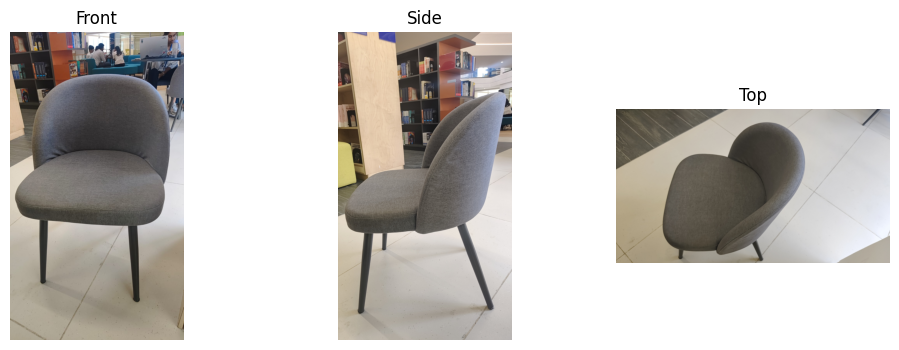

In [28]:
img_paths = [
    "/kaggle/input/samplechair/chair-front.jpeg",
    "/kaggle/input/samplechair/chair-side.png",
    "/kaggle/input/samplechair/chair-top.png"
]
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

# ✅ same transform as training
img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load and preprocess all views
imgs = [img_transform(Image.open(p).convert("RGB")) for p in img_paths]
imgs = torch.stack(imgs, dim=0).unsqueeze(0).to(device)  # shape (1, 3, 3, 128, 128)

# Visualize input views
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (p, ax) in enumerate(zip(img_paths, axes)):
    ax.imshow(Image.open(p))
    ax.axis('off')
    ax.set_title(["Front", "Side", "Top"][i])
plt.show()



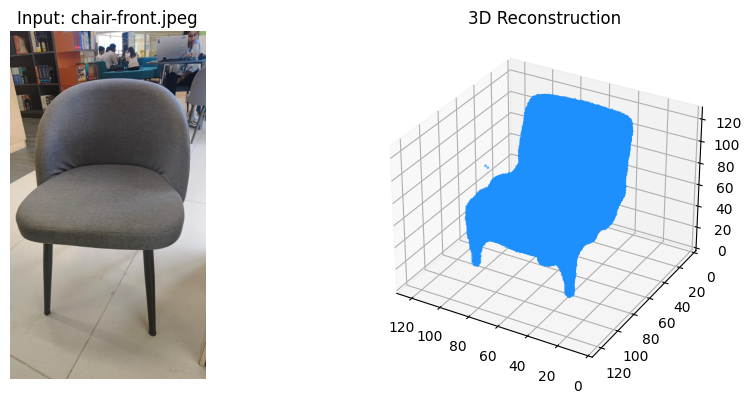

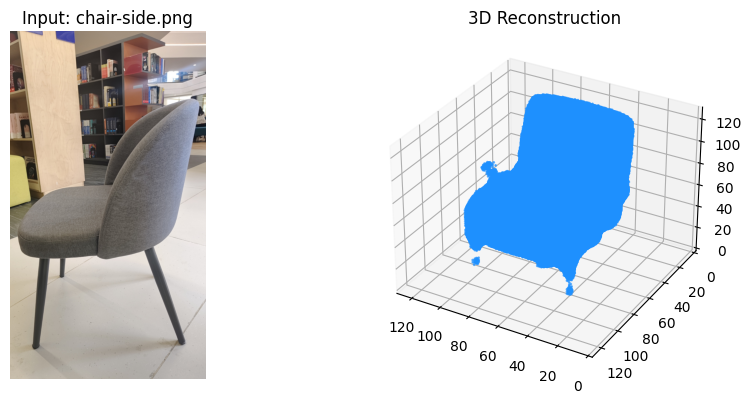

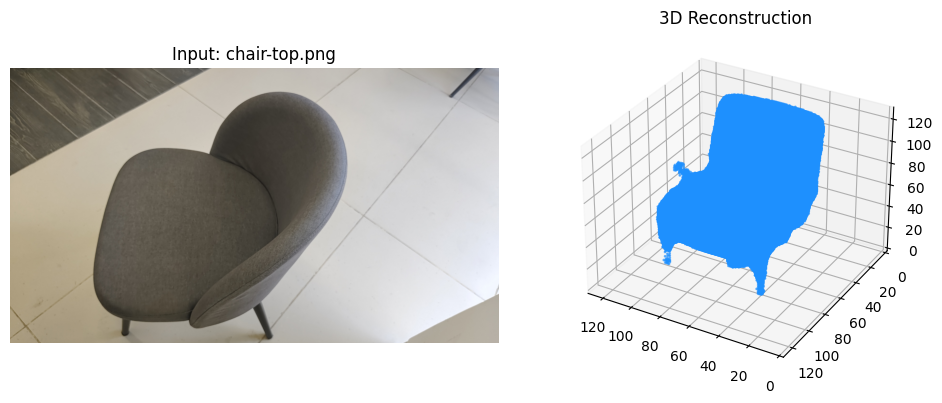

In [29]:
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Image paths
img_paths = [
    "/kaggle/input/samplechair/chair-front.jpeg",
    "/kaggle/input/samplechair/chair-side.png",
    "/kaggle/input/samplechair/chair-top.png"
]

# Preprocess transform
img_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

model_128.eval()

for path in img_paths:
    # Load and preprocess
    img = Image.open(path).convert("RGB")
    img_tensor = img_transform(img).unsqueeze(0).to(device)

    # Predict voxel grid
    with torch.no_grad():
        pred = model_128(img_tensor)

    # Convert to binary voxel grid
    vox = (pred[0,0].cpu().numpy() > 0.5).astype(np.uint8)

    # Plot
    pts = np.argwhere(vox)
    fig = plt.figure(figsize=(10,4))
    
    # Show input
    ax1 = fig.add_subplot(121)
    ax1.imshow(img)
    ax1.axis('off')
    ax1.set_title(f"Input: {path.split('/')[-1]}")
    
    # Show reconstruction
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(pts[:,0], pts[:,1], pts[:,2], s=1, c='dodgerblue', alpha=0.6)
    ax2.set_xlim(0,128); ax2.set_ylim(0,128); ax2.set_zlim(0,128)
    ax2.view_init(30, 120)
    ax2.set_title("3D Reconstruction")
    
    plt.tight_layout()
    plt.show()


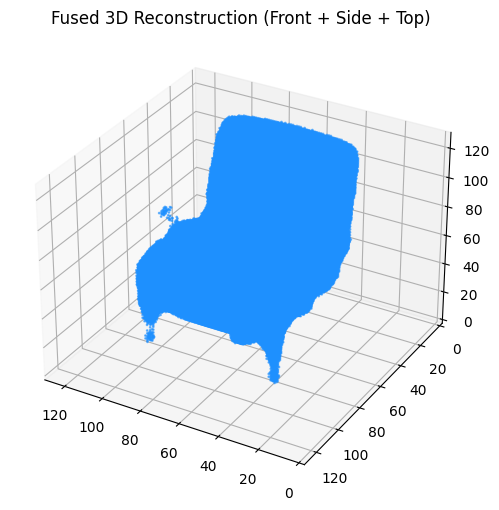

In [30]:
imgs = [img_transform(Image.open(p).convert("RGB")).unsqueeze(0).to(device) for p in img_paths]
model_128.eval()

with torch.no_grad():
    preds = [model_128(img) for img in imgs]

# Average voxel predictions
avg_pred = torch.mean(torch.stack(preds), dim=0)
vox_fused = (avg_pred[0,0].cpu().numpy() > 0.5).astype(np.uint8)

# Plot fused reconstruction
pts = np.argwhere(vox_fused)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1, c='dodgerblue', alpha=0.6)
ax.set_xlim(0,128); ax.set_ylim(0,128); ax.set_zlim(0,128)
ax.view_init(30, 120)
ax.set_title("Fused 3D Reconstruction (Front + Side + Top)")
plt.show()
